### Business Problem
A radiology consultancy looking to automate some of their work. While the consultancy as a whole specializes in providing detailed analyses of radiographs, a particularly common task for the consultancy is identifying cases of pneumonia from chest x-rays. Using neural networks, it may be possible to identify these cases more effieciently than through manual analysis, saving both time and money.

In [1]:
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.ticker as mtick
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import felzenszwalb, flood_fill, flood
from skimage.color import gray2rgb, rgb2gray
from os.path import exists

In [2]:
n_train_normal = len(os.listdir('../data/train/NORMAL'))
n_train_pneumonia = len(os.listdir('../data/train/PNEUMONIA'))

n_test_normal = len(os.listdir('../data/test/NORMAL'))
n_test_pneumonia = len(os.listdir('../data/test/PNEUMONIA'))

n_val_normal = len(os.listdir('../data/val/NORMAL'))
n_val_pneumonia = len(os.listdir('../data/val/PNEUMONIA'))

n_total_normal = n_train_normal + n_test_normal + n_val_normal
n_total_pneumonia = n_train_pneumonia + n_test_pneumonia + n_val_pneumonia
n_total_all = n_total_normal + n_total_pneumonia
percentage_normal = n_total_normal/n_total_all
percentage_pneumonia = n_total_pneumonia/n_total_all

print('Total images:', n_total_all)
print('Total normal images:', n_total_normal)
print('Total pneumonia images:', n_total_pneumonia)
print('Train set counts (Normal, Pneumonia):', str(n_train_normal) + ',', n_train_pneumonia)
print('Test set counts (Normal, Pneumonia):', str(n_test_normal) + ',', n_test_pneumonia)
print('Validation set counts (Normal, Pneumonia):', str(n_val_normal) + ',', n_val_pneumonia)
print('Percentage image distribution (Normal, Pneumonia)', 
      "{:.2%}".format(percentage_normal) + ',', 
      "{:.2%}".format(percentage_pneumonia))

Total images: 5856
Total normal images: 1583
Total pneumonia images: 4273
Train set counts (Normal, Pneumonia): 1267, 3419
Test set counts (Normal, Pneumonia): 158, 427
Validation set counts (Normal, Pneumonia): 158, 427
Percentage image distribution (Normal, Pneumonia) 27.03%, 72.97%


Text(1.93, 0.7796789617486339, '72.97%')

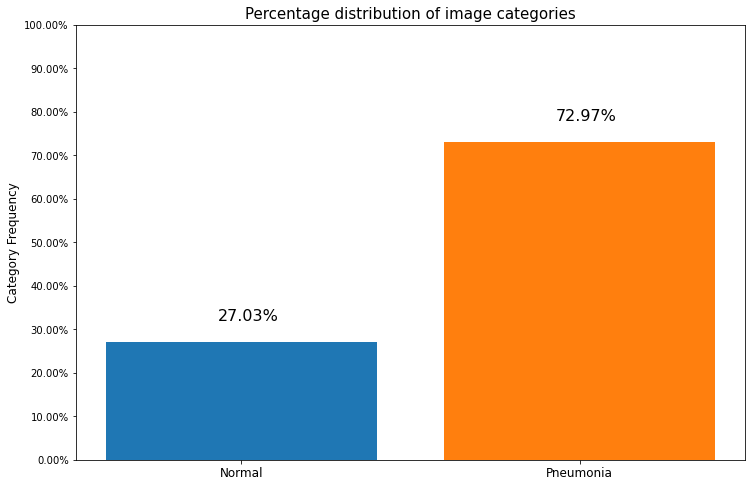

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(1, percentage_normal, label='Normal')
ax.bar(2, percentage_pneumonia, label='Pneumonia')
#ax.legend()
ax.set_title('Percentage distribution of image categories', fontsize=15)
plt.xticks([1,2],['Normal', 'Pneumonia'], fontsize=12)
plt.tick_params(
    axis='x',
    which='minor',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Category Frequency', fontsize=12)
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.text(1 -0.07, percentage_normal + 0.05, "{:.2%}".format(percentage_normal), fontsize=16)
plt.text(2 -0.07, percentage_pneumonia + 0.05, "{:.2%}".format(percentage_pneumonia), fontsize=16)

Text(0.5, 1.0, 'PNEUMONIA')

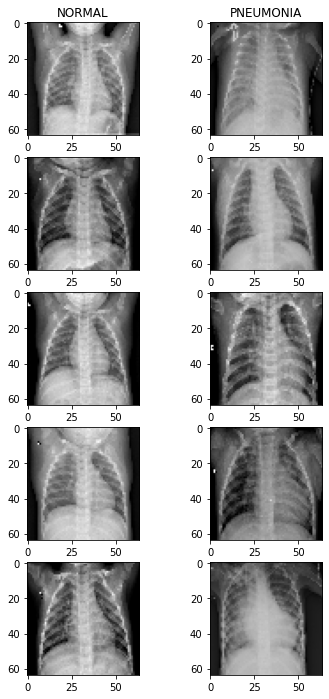

In [4]:
fig, ax = plt.subplots(figsize=(6,12), nrows=5, ncols=2)
ax[:, 0]

def showImgs(axList, path):
    w = 0
    for filename in os.listdir(path):
        if w < len(axList):
            #print(filename)
            img = load_img(path+filename, target_size=(64,64))
            axList[w].imshow(img)
            w += 1

showImgs(ax[:,0], '../data/train/NORMAL/')
showImgs(ax[:,1], '../data/train/PNEUMONIA/')
ax[0,0].set_title('NORMAL')
ax[0,1].set_title('PNEUMONIA')

### Data Preprocessing
The images are arranged into train, test, and validation sets.

Then, the images have their sizes standardized.
The images are resized to ensure input consistency and allow for efficient training performance.
Then, the resized images are arranged into train, test, and validation sets.

In the case of some models, data augmentation is also implemented, applying various transformations to the training set.


In [5]:
#check if images have already been resized
image_sizes = [512, 128, 64]

resized_set_sizes = []

stock_path = '../data/resized'

for size in image_sizes:
    image_counts = []
    resize_path = stock_path+str(size)+'/'
    #print(resize_path)
    for image_set in os.listdir(resize_path):
        set_path = resize_path + image_set + '/'
        #print(set_path)
        for folder in os.listdir(set_path):
            folder_path = set_path + folder + '/'
            folder_size = len(os.listdir(folder_path))
            #print(folder_path, folder_size)
            image_counts.append(folder_size)
    resized_set_sizes.append(image_counts)
    
#print(resized_set_sizes)

correct_set_sizes = [[158, 427, 1267, 3419, 158, 427], 
                     [158, 427, 1267, 3419, 158, 427], 
                     [158, 427, 1267, 3419, 158, 427]]

if resized_set_sizes == correct_set_sizes:
    images_resized = True
else:
    images_resized = False
    
print('Images already resized:', images_resized)

Images already resized: True


In [6]:
#if images haven't been resized, resize them
if images_resized == False:

    #data dirs
    train_dir = '../data/train'
    test_dir = '../data/test'
    val_dir = '../data/val'

    #image sizes aren't standard
    #preprocess and save to new dir
    dirs = [train_dir, test_dir, val_dir]



    for size in image_sizes:
        print('Resizing to', size)
        for data_dir in dirs:
            print('Starting on dir', data_dir)
            for folder in os.listdir(data_dir):
                new_path = data_dir + '/' + folder
                for img_path in os.listdir(new_path):
                    full_path = new_path + '/' + img_path
                    print(full_path)
                    preprocess_path = full_path[:8] + 'resized' + str(size) + '/' + full_path[8:]

                    img = Image.open(full_path)
                    new_width  = size
                    new_height = size
                    img = img.resize((new_width, new_height), Image.ANTIALIAS)
                    img.save(preprocess_path)
                    print(preprocess_path)
                    print('----------')

In [7]:
#choose image size to use
select_size=64

#choose batch size for each set
batch_size_train = 1600 #max is 4686
batch_size_test = 200   #max is 585
batch_size_val = 200    #max is 585

#new data dirs
train_dir = '../data/resized' + str(select_size) + '/train'
test_dir = '../data/resized' + str(select_size) + '/test'
val_dir = '../data/resized' + str(select_size) + '/val'

#create generators
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_test,
        color_mode='grayscale') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_val,
        color_mode='grayscale')

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=batch_size_train,
        color_mode='grayscale')

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [8]:
#prepare dataset for baseline model
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

train_y = np.reshape(train_labels[:,1], (-1,1))
test_y = np.reshape(test_labels[:,1], (-1,1))
val_y = np.reshape(val_labels[:,1], (-1,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

Number of training samples: 1600
Number of testing samples: 200
Number of validation samples: 200
train_images shape: (1600, 64, 64, 1)
train_labels shape: (1600, 2)
test_images shape: (200, 64, 64, 1)
test_labels shape: (200, 2)
val_images shape: (200, 64, 64, 1)
val_labels shape: (200, 2)
(1600, 4096)
(200, 4096)
(200, 4096)
(1600, 1)
(200, 1)
(200, 1)


Image Label: [0.]


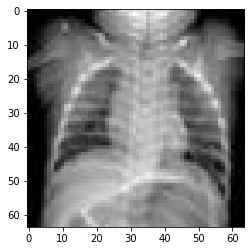

1.0    1165
0.0     435
dtype: int64

In [9]:
#check which category got which label
#in this case, normal is marked as 0 and pneumonia as 1
sample_image = train_images[180]
sample_label = train_y[180]
display(plt.imshow(sample_image, cmap='gray'))
print('Image Label: {}'.format(sample_label))
plt.show()

#sample_image = train_images[181]
#sample_label = train_y[181]
#display(plt.imshow(sample_image, cmap='gray'))
#print('Image Label: {}'.format(sample_label))
#plt.show()


pd.DataFrame(train_y).value_counts()


In [10]:
#call metrics seperately to avoid rename when retraining
metric_recall = metrics.Recall()
metric_precision = metrics.Precision()

In [11]:
#save model history
def saveModelHistory(result_model, path):
    hist_df = pd.DataFrame(result_model.history)
    hist_json_file = path 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

In [12]:
#baseline model
if exists('../models/baseline.h5'):
    baseline = models.load_model('../models/baseline.h5')
    baseline_history = pd.read_json('../models/hist_baseline.json')
else:
    baseline = models.Sequential()
    baseline.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],))) 
    baseline.add(layers.Dense(7, activation='relu'))
    baseline.add(layers.Dense(5, activation='relu'))
    baseline.add(layers.Dense(1, activation='sigmoid'))

    baseline.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=[metric_recall, metric_precision, 'acc'])

    result_baseline = baseline.fit(train_img,
                            train_y,
                            epochs=40,
                            batch_size=32,
                            validation_data=(val_img, val_y))
    baseline_history = result_baseline.history


        
    saveModelHistory(result_baseline, '../models/hist_baseline.json')

7/7 [==============================] - 0s 1ms/step - loss: 0.5379 - recall: 0.9933 - precision: 0.8362 - acc: 0.8500


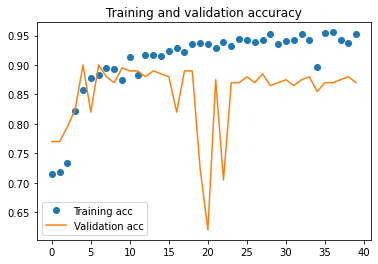

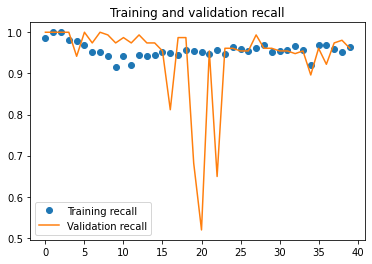

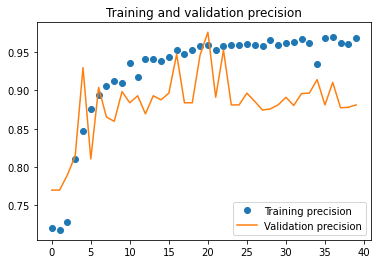

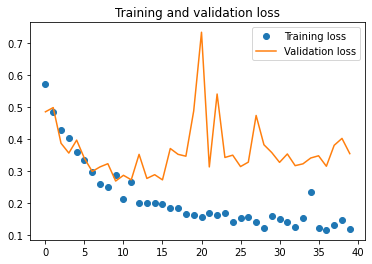

In [13]:
def plotResults(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    precision = history['precision']
    val_precision = history['val_precision']
    recall = history['recall']
    val_recall = history['val_recall']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'o', label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, recall, 'o', label='Training recall')
    plt.plot(epochs, val_recall, label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, precision, 'o', label='Training precision')
    plt.plot(epochs, val_precision, label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'o', label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
baseline.evaluate(test_img, test_y)

plotResults(baseline_history)
baseline.save('../models/baseline.h5')

In [14]:
#create conv model

if exists('../models/conv1.h5'):
    model_conv = models.load_model('../models/conv1.h5')
    conv_history = pd.read_json('../models/hist_conv1.json')
else:
    model_conv = models.Sequential()
    model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(select_size, select_size, 1)))
    model_conv.add(layers.MaxPooling2D((2, 2)))

    model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model_conv.add(layers.MaxPooling2D((2, 2)))

    model_conv.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model_conv.add(layers.MaxPooling2D((2, 2)))

    model_conv.add(layers.Flatten())
    model_conv.add(layers.Dense(800, activation='relu'))
    model_conv.add(layers.Dense(1, activation='sigmoid'))

    model_conv.compile(loss='binary_crossentropy',
                  optimizer="sgd",
                  metrics=[metric_recall, metric_precision, 'acc'])

    results_conv = model_conv.fit(train_images,
                                  train_y,
                                    epochs=20,
                                    batch_size=32,
                                    validation_data=(val_images, val_y))
    conv_history = results_conv.history

    saveModelHistory(results_conv, '../models/hist_conv1.json')

7/7 [==============================] - 0s 34ms/step - loss: 0.3297 - recall: 0.9866 - precision: 0.8698 - acc: 0.8800


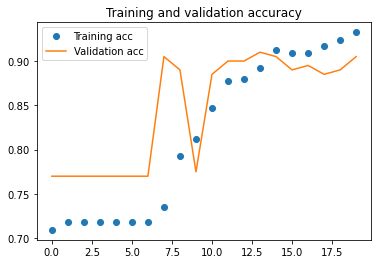

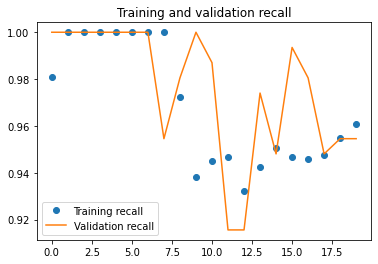

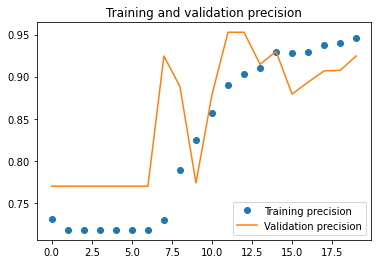

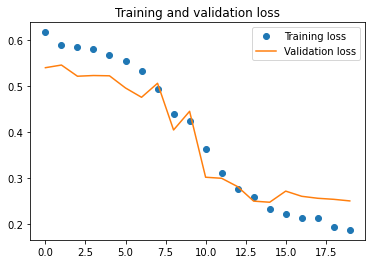

In [15]:
model_conv.evaluate(test_images, test_y)
plotResults(conv_history)

model_conv.save('../models/conv1.h5')

In [16]:
#setup data augmentation
train_gen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

train_aug_generator = train_gen_aug.flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=batch_size_train,
        color_mode='grayscale')

train_aug_images, train_aug_labels = next(train_generator)
train_aug_y = np.reshape(train_aug_labels[:,1], (-1,1))


Found 4686 images belonging to 2 classes.


../data/resized64/train/NORMAL/IM-0115-0001.jpeg


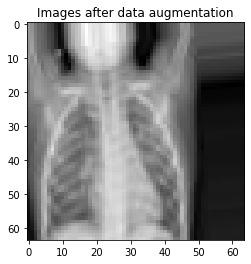

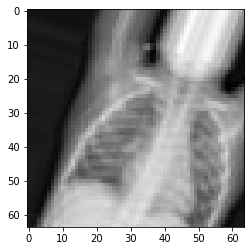

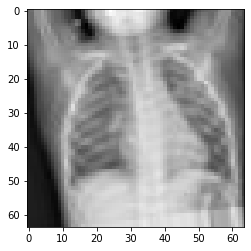

In [17]:
aug_show_dir = train_dir + '/' + os.listdir(train_dir)[0] + '/'
aug_show_dir = aug_show_dir + os.listdir(aug_show_dir)[0]
print(aug_show_dir)

img = load_img(aug_show_dir, target_size=(select_size, select_size))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
w=0
for batch in train_gen_aug.flow(reshape_img, batch_size=1):
    plt.figure(w)
    imgplot = plt.imshow(array_to_img(batch[0]))
    if w == 0:
        plt.title('Images after data augmentation')
    w += 1
    if w % 3 == 0:
        break
        

plt.show()

In [18]:
#setup early stopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True), 
                  ModelCheckpoint(filepath='../models/checkpointTemp.h5', monitor='val_loss', save_best_only=True)]


In [19]:
if exists('../models/convDataAug.h5'):
    model_conv_aug = models.load_model('../models/convDataAug.h5')
    conv_aug_history = pd.read_json('../models/hist_convDataAug.json')
else:
    model_conv_aug = models.Sequential()
    model_conv_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(select_size, select_size, 1)))
    model_conv_aug.add(layers.MaxPooling2D((2, 2)))

    model_conv_aug.add(layers.Conv2D(64, (3, 3),
                                     activation='relu'))
    model_conv_aug.add(layers.MaxPooling2D((2, 2)))

    model_conv_aug.add(layers.Conv2D(128, (5, 5),
                                     activation='relu'))
    model_conv_aug.add(layers.MaxPooling2D((2, 2)))

    model_conv_aug.add(layers.Flatten())
    model_conv_aug.add(layers.Dense(800, activation='relu'))
    model_conv_aug.add(layers.Dense(400, activation='relu'))
    model_conv_aug.add(layers.Dense(1, activation='sigmoid'))

    model_conv_aug.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])

    results_conv_aug = model_conv_aug.fit(train_aug_images,
                                          train_aug_y,
                                          epochs=30,
                                          batch_size=32,
                                          validation_data=(val_images, val_y),
                                          callbacks=early_stopping)
    conv_aug_history = results_conv_aug.history

    saveModelHistory(results_conv_aug, '../models/hist_convDataAug.json')

7/7 [==============================] - 0s 32ms/step - loss: 0.2924 - recall: 0.9799 - precision: 0.8848 - acc: 0.8900


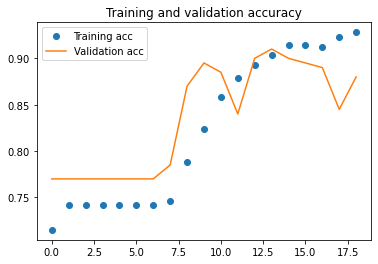

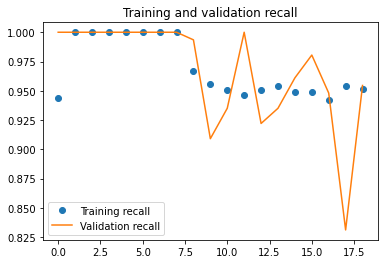

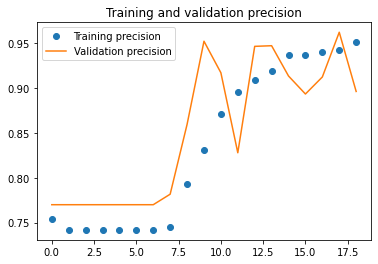

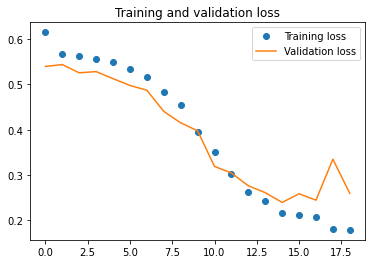

In [20]:
model_conv_aug.evaluate(test_images, test_y)
plotResults(conv_aug_history)
model_conv_aug.save('../models/convDataAug.h5')

In [37]:
#setup custom decision threshold
threshold = 0.2
predictions_raw = model_conv_aug.predict(test_images)
preds = predictions_raw > threshold
print('Recall:', recall_score(test_y, preds))
print('Precision:', precision_score(test_y, preds))
print('Accuracy:', accuracy_score(test_y, preds))

Recall: 0.9865771812080537
Precision: 0.8121546961325967
Accuracy: 0.82


In [22]:
#setup feature extraction
#load images in color

test_generator_color = train_gen_aug.flow_from_directory(
        test_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_test) 

val_generator_color = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_val)

train_generator_color = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=batch_size_train)

train_images_color, train_labels_color = next(train_generator_color)
test_images_color, test_labels_color = next(test_generator_color)
val_images_color, val_labels_color = next(val_generator_color)

train_y_color = np.reshape(train_labels_color[:,1], (-1,1))
test_y_color = np.reshape(test_labels_color[:,1], (-1,1))
val_y_color = np.reshape(val_labels_color[:,1], (-1,1))




#load model

vgg = VGG19(weights='imagenet',
           include_top=False,
           input_shape=(select_size, select_size, 3))

vgg.trainable = False

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [23]:
if exists('../models/transfer1.h5'):
    model_transfer = models.load_model('../models/transfer1.h5')
    transfer_history = pd.read_json('../models/hist_transfer1.json')
else:
    model_transfer = models.Sequential()
    model_transfer.add(vgg)

    model_transfer.add(layers.Flatten())
    model_transfer.add(layers.Dense(1024, activation='relu'))
    model_transfer.add(layers.Dense(1, activation='sigmoid'))

    model_transfer.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])

    for layer in model_transfer.layers:
        print(layer.name, 'Trainable:', layer.trainable)

    results_transfer = model_transfer.fit(train_images_color,
                                          train_y_color,
                                          epochs=30,
                                          batch_size=32,
                                          validation_data=(val_images_color, val_y_color),
                                          callbacks=early_stopping)
    transfer_history = results_transfer.history

    saveModelHistory(results_transfer, '../models/hist_transfer1.json')

7/7 [==============================] - 6s 824ms/step - loss: 0.7132 - recall: 1.0000 - precision: 0.7268 - acc: 0.7350


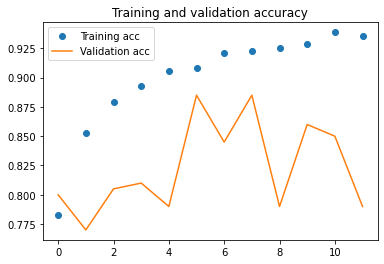

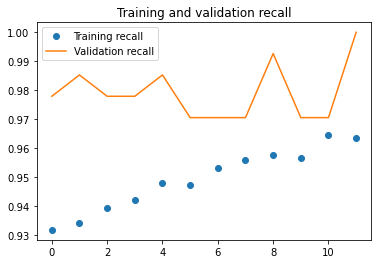

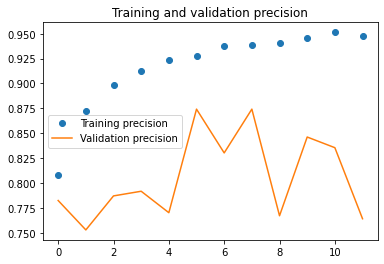

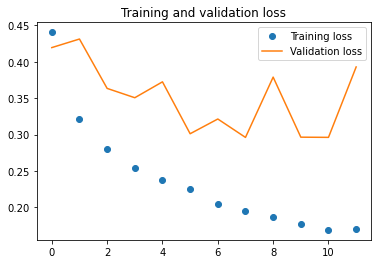

In [24]:
model_transfer.evaluate(test_images_color, test_y_color)
plotResults(transfer_history)
model_transfer.save('../models/transfer1.h5')

In [25]:
predictions_raw = model_transfer.predict(test_images_color)

In [26]:
threshold = 0.6
preds = predictions_raw > threshold
print('Recall:', recall_score(test_y_color, preds))
print('Precision:', precision_score(test_y_color, preds))
print('Accuracy:', accuracy_score(test_y_color, preds))

Recall: 1.0
Precision: 0.7382198952879581
Accuracy: 0.75


In [27]:
vgg_tune = VGG19(weights='imagenet',
           include_top=False,
           input_shape=(select_size, select_size, 3))


for layer in vgg_tune.layers:
    if 'block5' not in layer.name:
        layer.trainable = False
        
for layer in vgg_tune.layers:
    print(layer.name, 'Trainable:', layer.trainable)

input_2 Trainable: False
block1_conv1 Trainable: False
block1_conv2 Trainable: False
block1_pool Trainable: False
block2_conv1 Trainable: False
block2_conv2 Trainable: False
block2_pool Trainable: False
block3_conv1 Trainable: False
block3_conv2 Trainable: False
block3_conv3 Trainable: False
block3_conv4 Trainable: False
block3_pool Trainable: False
block4_conv1 Trainable: False
block4_conv2 Trainable: False
block4_conv3 Trainable: False
block4_conv4 Trainable: False
block4_pool Trainable: False
block5_conv1 Trainable: True
block5_conv2 Trainable: True
block5_conv3 Trainable: True
block5_conv4 Trainable: True
block5_pool Trainable: True


In [28]:

if exists('../models/transfer2.h5'):
    model_transfer_tune = models.load_model('../models/transfer2.h5')
    transfer_tune_history = pd.read_json('../models/hist_transfer2.json')
else:
    model_transfer_tune = models.Sequential()
    model_transfer_tune.add(vgg_tune)

    model_transfer_tune.add(layers.Flatten())
    model_transfer_tune.add(layers.Dense(1024, activation='relu'))
    model_transfer_tune.add(layers.Dense(1, activation='sigmoid'))

    model_transfer_tune.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])


    results_transfer_tune = model_transfer_tune.fit(train_images_color,
                                               train_y_color,
                                               epochs=30,
                                               batch_size=32,
                                               validation_data=(val_images_color, val_y_color),
                                               callbacks=early_stopping)
    transfer_tune_history = results_transfer_tune.history

    saveModelHistory(results_transfer_tune, '../models/hist_transfer2.json')

7/7 [==============================] - 6s 832ms/step - loss: 0.4878 - recall: 0.9858 - precision: 0.7943 - acc: 0.8100


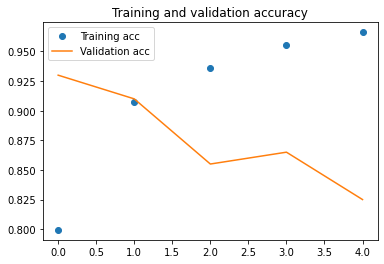

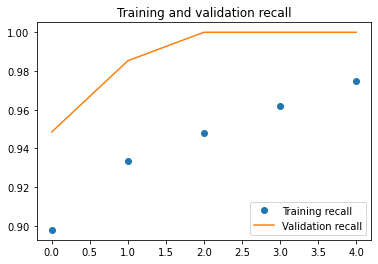

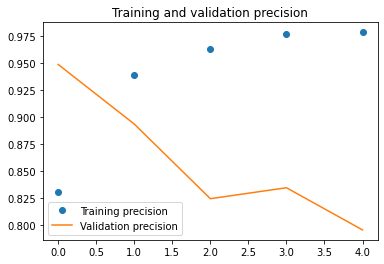

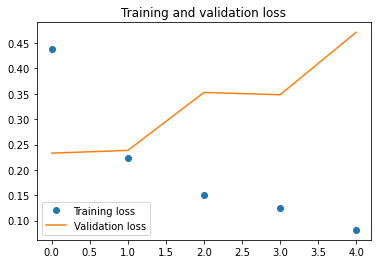

In [29]:
model_transfer_tune.evaluate(test_images_color, test_y_color)
plotResults(transfer_tune_history)
model_transfer_tune.save('../models/transfer2.h5')

In [30]:
predictions_raw = model_transfer_tune.predict(test_images_color)

In [31]:
threshold = 0.4
preds = predictions_raw > threshold
print('Recall:', recall_score(test_y_color, preds))
print('Precision:', precision_score(test_y_color, preds))
print('Accuracy:', accuracy_score(test_y_color, preds))

Recall: 1.0
Precision: 0.7663043478260869
Accuracy: 0.785


In [32]:
#setup lime visual


In [33]:
explainer = lime_image.LimeImageExplainer()
type(explainer)

lime.lime_image.LimeImageExplainer

In [34]:
def make_prediction(color_img):
    gray_img = rgb2gray(color_img).reshape(-1,64,64,1)
    preds = model_conv_aug.predict(gray_img)
    print(preds)
    return preds

colored_image = gray2rgb(test_images[8].squeeze())

preds = make_prediction(colored_image)

#print(preds)
print(test_y[8])

[[0.9782107]]
[1.]


In [35]:
idx = 8


explanation = explainer.explain_instance(test_images[idx].squeeze(), make_prediction)

explanation

[[0.9782107 ]
 [0.99484384]
 [0.99484384]
 [0.9782107 ]
 [0.997872  ]
 [0.99484384]
 [0.9693954 ]
 [0.99012834]
 [0.9782107 ]
 [0.9693954 ]]
[[0.98726606]
 [0.997872  ]
 [0.9947958 ]
 [0.99444133]
 [0.997872  ]
 [0.98726606]
 [0.98726606]
 [0.98726606]
 [0.99484384]
 [0.9693954 ]]
[[0.9947958 ]
 [0.99012834]
 [0.9693954 ]
 [0.99012834]
 [0.99484384]
 [0.99444133]
 [0.9782107 ]
 [0.9947958 ]
 [0.98726606]
 [0.99012834]]
[[0.99484384]
 [0.99484384]
 [0.9947958 ]
 [0.9947958 ]
 [0.997872  ]
 [0.9947958 ]
 [0.9693954 ]
 [0.98726606]
 [0.9782107 ]
 [0.9782107 ]]
[[0.997872  ]
 [0.9947958 ]
 [0.9693954 ]
 [0.9782107 ]
 [0.99444133]
 [0.9782107 ]
 [0.99484384]
 [0.99484384]
 [0.98726606]
 [0.99012834]]
[[0.9693954 ]
 [0.99444133]
 [0.997872  ]
 [0.99444133]
 [0.9782107 ]
 [0.997872  ]
 [0.98726606]
 [0.997872  ]
 [0.9782107 ]
 [0.9947958 ]]
[[0.9782107 ]
 [0.9693954 ]
 [0.98726606]
 [0.99444133]
 [0.99444133]
 [0.99012834]
 [0.9947958 ]
 [0.9782107 ]
 [0.9947958 ]
 [0.997872  ]]
[[0.997872  ]

[[0.99484384]
 [0.9782107 ]
 [0.99012834]
 [0.98726606]
 [0.99484384]
 [0.99444133]
 [0.98726606]
 [0.98726606]
 [0.9693954 ]
 [0.98726606]]
[[0.9782107 ]
 [0.9782107 ]
 [0.99444133]
 [0.997872  ]
 [0.99484384]
 [0.99444133]
 [0.98726606]
 [0.98726606]
 [0.99484384]
 [0.9693954 ]]
[[0.9947958 ]
 [0.99012834]
 [0.997872  ]
 [0.9947958 ]
 [0.9947958 ]
 [0.9782107 ]
 [0.99484384]
 [0.99444133]
 [0.99484384]
 [0.9947958 ]]
[[0.9947958 ]
 [0.997872  ]
 [0.99484384]
 [0.98726606]
 [0.99484384]
 [0.9693954 ]
 [0.98726606]
 [0.98726606]
 [0.99484384]
 [0.99484384]]
[[0.99444133]
 [0.9947958 ]
 [0.997872  ]
 [0.99012834]
 [0.9947958 ]
 [0.9947958 ]
 [0.99484384]
 [0.98726606]
 [0.99012834]
 [0.99484384]]
[[0.99444133]
 [0.99484384]
 [0.99484384]
 [0.99484384]
 [0.997872  ]
 [0.9782107 ]
 [0.9693954 ]
 [0.9782107 ]
 [0.997872  ]
 [0.9782107 ]]
[[0.9693954 ]
 [0.99444133]
 [0.9947958 ]
 [0.997872  ]
 [0.9947958 ]
 [0.9693954 ]
 [0.9947958 ]
 [0.997872  ]
 [0.9693954 ]
 [0.9947958 ]]
[[0.9947958 ]

In [36]:
#make_prediction(gray2rgb(test_images[idx].squeeze()))

img, mask = explanation.get_image_and_mask(test_y[idx], positive_only=True, hide_rest=True)


img.shape, mask.shape

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
threshold = 0.4
predictions_raw = model_conv_aug.predict(test_images)
preds = []
for val in predictions_raw:
    if val > threshold:
        preds.append(1)
    else:
        preds.append(0)
print('Recall:', recall_score(test_y, preds))
print('Precision:', precision_score(test_y, preds))
print('Accuracy:', accuracy_score(test_y, preds))

print(confusion_matrix(test_y, preds))
print(classification_report(test_y, preds))

In [ ]:
threshold_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

thresh_results = {}

for threshold in threshold_list:
    predictions_raw = model_conv_aug.predict(test_images)
    preds = []
    for val in predictions_raw:
        if val > threshold:
            preds.append(1)
        else:
            preds.append(0)
    thresh_results[threshold] = preds

In [ ]:
thresh_recall = {}
thresh_precision = {}

for key in thresh_results.keys():
    thresh_recall[key] = recall_score(test_y, thresh_results[key])
    thresh_precision[key] = precision_score(test_y, thresh_results[key])
    
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(thresh_results.keys(), thresh_recall.values(), label='Recall')
ax.plot(thresh_results.keys(), thresh_precision.values(), label='Precision')

ax.set_ylabel('Metric Score')
ax.set_xlabel('Decision Threshold')
for key in thresh_results.keys():
    ax.axvline(key, color='gray')
    
ax.set_title('Precision and Recall scores by threshold value')
plt.legend()

In [ ]:
#model_conv_aug.evaluate(test_images, test_y)
model_scores = {
    'Baseline' : baseline.evaluate(test_img, test_y),
    'Basic Convolutional' : model_conv.evaluate(test_images, test_y),
    'Convolutional w/ Augmentation' : model_conv_aug.evaluate(test_images, test_y),
#    'Transfer Learning, Feature Extraction' = model_transfer.evaluate(test_images_color, test_y_color),
#    'Transfer Learning, Fine Tuning' = model_transfer_tune.evaluate(test_images_color, test_y_color),
#    'Final Model' = model_final.evaluate(test_images, test_y)
}

metric_list = ['Loss', 'Recall', 'Precision', 'Accuracy']
w = 0

fig, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
ax_list = ax.flatten()


for metric in metric_list:
    dfFind1 = pd.DataFrame([(x[w] for x in model_scores.values())], columns=model_scores.keys())
    dfFind1 = dfFind1.T
    dfFind1.columns = [metric]
    
    if w == 0:
        dfFind1.sort_values(by=metric, ascending=False, inplace=True)
    else:
        dfFind1.sort_values(by=metric, ascending=True, inplace=True)

    
    barList = ax_list[w].barh((range(len(model_scores))), dfFind1[metric], align='center')
    #barList[0].set_color('#FF9000')

    ax_list[w].set_yticks(np.arange(len(model_scores)))
    ax_list[w].set_yticklabels(dfFind1.index, rotation=15, fontsize=12)
    if w != 0:
        ax_list[w].set_xlim(0.5, 1.0)

    ax_list[w].set_title('Average ' + metric + ' Score per Model', fontsize=16)
    ax_list[w].set_ylabel('Model Name', fontsize=14)
    ax_list[w].set_xlabel('Average ' + metric + ' Score', fontsize=14)
    #plt.show()
    
    w += 1
    
fig.tight_layout()

In [ ]:
#maybe combine recall, precision, and acc to a single graph?